In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [3]:
df = pd.read_csv('/content/temizlendi_correctyapıldı_stoplarfalan_silinmedi_sadece1kere_gecenler_silindi.csv')

In [4]:
df = df.rename(columns={'idea': 'category', 'sentence': 'text'})
df.head()

,Unnamed: 0,text,category
0,1,we are clearly having a abc correction after w...,Short
1,2,we all know etc needs some correction order bl...,Short
2,3,hello traders on the daily time frame the btcu...,Short
3,4,the first day of the week has started with a v...,Short
4,5,a lot of investors are getting optimistic view...,Short


In [5]:
df.category.value_counts()

Long     3473
Short    2670
Name: category, dtype: int64

In [6]:
df.category.value_counts(normalize=True)

Long     0.565359
Short    0.434641
Name: category, dtype: float64

In [7]:
df

,Unnamed: 0,text,category
0,1,we are clearly having a abc correction after w...,Short
1,2,we all know etc needs some correction order bl...,Short
2,3,hello traders on the daily time frame the btcu...,Short
3,4,the first day of the week has started with a v...,Short
4,5,a lot of investors are getting optimistic view...,Short
...,...,...,...
6138,6139,there is we are range chart but i think good p...,Long
6139,6140,another close up view maybe i m wrong maybe no...,Short
6140,6141,as you can see there is an ascending wedge in ...,Long
6141,6142,it is expected that the price will change the ...,Short


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6143 entries, 0 to 6142
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6143 non-null   int64 
 1   text        6141 non-null   object
 2   category    6143 non-null   object
dtypes: int64(1), object(2)
memory usage: 144.1+ KB


In [9]:
df=df.dropna()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6141 entries, 0 to 6142
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6141 non-null   int64 
 1   text        6141 non-null   object
 2   category    6141 non-null   object
dtypes: int64(1), object(2)
memory usage: 191.9+ KB


In [11]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

<ipython-input-11-630fdbb30a02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])


In [12]:
df

,Unnamed: 0,text,category,encoded_categories
0,1,we are clearly having a abc correction after w...,Short,1
1,2,we all know etc needs some correction order bl...,Short,1
2,3,hello traders on the daily time frame the btcu...,Short,1
3,4,the first day of the week has started with a v...,Short,1
4,5,a lot of investors are getting optimistic view...,Short,1
...,...,...,...,...
6138,6139,there is we are range chart but i think good p...,Long,0
6139,6140,another close up view maybe i m wrong maybe no...,Short,1
6140,6141,as you can see there is an ascending wedge in ...,Long,0
6141,6142,it is expected that the price will change the ...,Short,1


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
sentences = df.text.values

In [15]:
max_len=375

In [16]:
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.text.values
training_labels = training.encoded_categories.values

Training:  4913
Test:  1228


In [17]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  bitcoin declining to test blue sad band on he after strong run up as price approached this level on smaller time frames hammered and confirmation as green candle buy let s see if buyers can push price higher to test top linger on he stop
Token IDs: tensor([  101,  2978,  3597,  2378, 13993,  2000,  3231,  2630,  6517,  2316,
         2006,  2002,  2044,  2844,  2448,  2039,  2004,  3976,  5411,  2023,
         2504,  2006,  3760,  2051, 11048, 25756,  1998, 13964,  2004,  2665,
        13541,  4965,  2292,  1055,  2156,  2065, 17394,  2064,  5245,  3976,
         3020,  2000,  3231,  2327, 26577,  2006,  2002,  2644,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   

In [18]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

number_of_categories = len(df['encoded_categories'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = number_of_categories,
    output_attentions = False,
    output_hidden_states = False,
    ignore_mismatched_sizes=True

)

model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [20]:
epochs = 10

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 10 ========
Batch    10  of    154.    Elapsed: 0:00:19.
Batch    20  of    154.    Elapsed: 0:00:38.
Batch    30  of    154.    Elapsed: 0:00:58.
Batch    40  of    154.    Elapsed: 0:01:18.
Batch    50  of    154.    Elapsed: 0:01:38.
Batch    60  of    154.    Elapsed: 0:01:59.
Batch    70  of    154.    Elapsed: 0:02:20.
Batch    80  of    154.    Elapsed: 0:02:40.
Batch    90  of    154.    Elapsed: 0:03:00.
Batch   100  of    154.    Elapsed: 0:03:21.
Batch   110  of    154.    Elapsed: 0:03:41.
Batch   120  of    154.    Elapsed: 0:04:02.
Batch   130  of    154.    Elapsed: 0:04:22.
Batch   140  of    154.    Elapsed: 0:04:43.
Batch   150  of    154.    Elapsed: 0:05:03.
Average training loss: 0.62
Training epoch took: 0:05:10
======== Epoch 2 / 10 ========
Batch    10  of    154.    Elapsed: 0:00:20.
Batch    20  of    154.    Elapsed: 0:00:41.
Batch    30  of    154.    Elapsed: 0:01:01.
Batch    40  of    154.    Elapsed: 0:01:22.
Batch    50  of    154.   

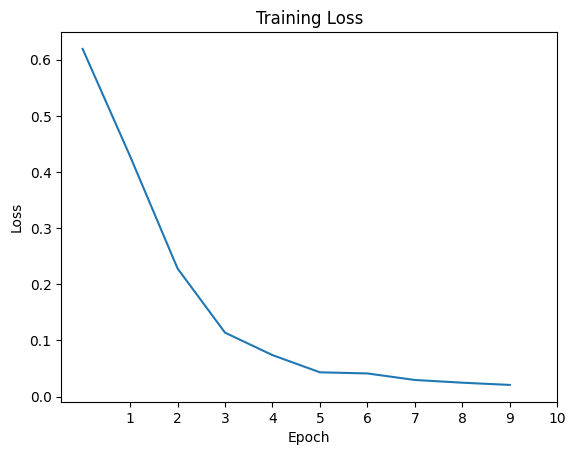

In [23]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

In [24]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [26]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'long',
                          '1':'short',
                          })

print(report)

F-Score:  0.787752591237697
Recall:  0.7857019503718334
Precision:  0.7912471805028333
                 long       short  accuracy    macro avg  weighted avg
precision    0.801370    0.781124   0.79316     0.791247      0.792566
recall       0.842939    0.728464   0.79316     0.785702      0.793160
f1-score     0.821629    0.753876   0.79316     0.787753      0.792166
support    694.000000  534.000000   0.79316  1228.000000   1228.000000


In [27]:
report

,long,short,accuracy,macro avg,weighted avg
precision,0.801370,0.781124,0.79316,0.791247,0.792566
recall,0.842939,0.728464,0.79316,0.785702,0.793160
f1-score,0.821629,0.753876,0.79316,0.787753,0.792166
support,694.000000,534.000000,0.79316,1228.000000,1228.000000
